In [1]:
%matplotlib inline

import json
import pandas as pd
import seaborn as sns

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', 40)
sns.set_style("darkgrid")
sns.set_context(rc={"figure.figsize": (8, 6)})

In [2]:
with open('data/commits.json') as f:
    data = json.load(f)

In [3]:
# clean up & remove unneeded fields

cleaned = []

for repo, commits in data.items():
    for c in commits:
        info = c['commit']
        stats = c['stats']
        details = [
            { k: f[k] for k in ['additions', 'deletions', 'changes', 'filename'] }
            for f in c['files']
        ]

        cleaned.append({
            'dt': info['author']['date'],
            'sha': c['sha'],
            'url': c['html_url'],
            'repo': repo,
            'username': (c.get('author') or {}).get('login'),
            'name': info['author']['name'].lower(),
            'message': info['message'],
            'additions': stats['additions'],
            'deletions': stats['deletions'],
            'total': stats['total'],
            'details': details,
        })

# save locally
with open('data/commits-cleaned.json', 'w') as f:
    json.dump(cleaned, f, ensure_ascii=False)

In [4]:
# convert to pandas dataframe and explore 

df = pd.DataFrame(cleaned)

df['dt'] = pd.to_datetime(df['dt'])
df.sort_values(by='dt', inplace=True)

df['date'] = df['dt'].apply(lambda x: x.date())
df['month'] = df['dt'].apply(lambda x: x.month)
df['dow'] = df['dt'].apply(lambda x: x.dayofweek)
df['hour'] = df['dt'].apply(lambda x: (x.hour - 4) % 24) # convert to eastern

df.iloc[0]

additions                                                 1217
deletions                                                    0
details      [{'additions': 127, 'filename': 'cf-deployment...
dt                                         2015-03-05 21:10:46
message                                Keep only small release
name                                             diego lapiduz
repo                                              cg-deploy-cf
sha                   cd5cf97664cd678237aabadde414b0f9c54d72cf
total                                                     1217
url          https://github.com/18F/cg-deploy-cf/commit/cd5...
username                                              dlapiduz
date                                                2015-03-05
month                                                        3
dow                                                          3
hour                                                        17
Name: 61672, dtype: object

In [5]:
# how many total commits?

len(df)

78785

In [6]:
# summary stats of lines added/deleted per commit

print(df[['additions', 'deletions', 'total']].describe())

        additions   deletions       total
count   78785.000   78785.000   78785.000
mean      575.284     313.303     888.586
std     15829.208   13651.792   21296.106
min         0.000       0.000       0.000
25%         2.000       1.000       4.000
50%         8.000       3.000      14.000
75%        41.000      14.000      63.000
max   1639862.000 1647305.000 1695259.000


In [7]:
# summary stats of commits per day (weekdays only)

df.query('dow < 5').groupby('date').size().describe()

count   391.000
mean    189.872
std     103.111
min       1.000
25%     154.000
50%     219.000
75%     259.500
max     414.000
dtype: float64

In [8]:
# who's working on weekends? :)

df.query('dow >= 5').groupby('name').size().sort_values(ascending=False)[:5]

name
tom lane          196
aidan feldman     192
adrian webb       186
laura gerhardt    151
joshua carp       138
dtype: int64

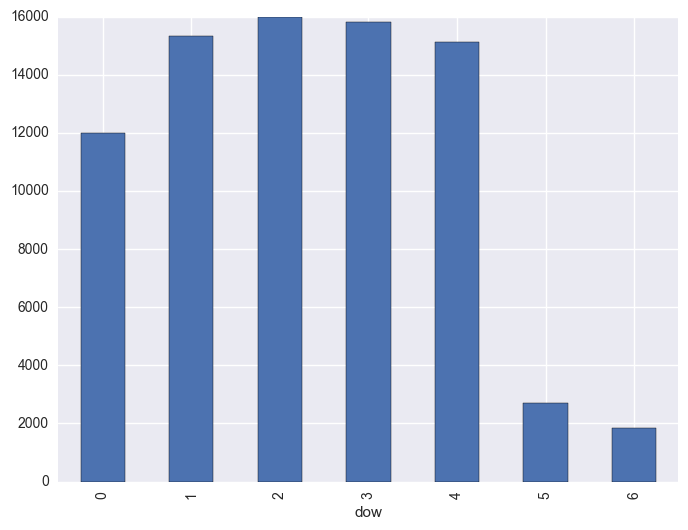

In [9]:
# commits by day of the week

df.groupby('dow').size().plot(kind='bar')

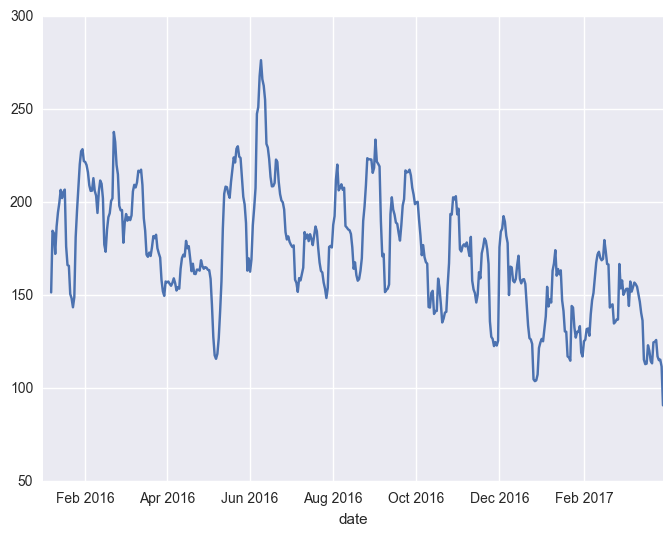

In [10]:
# commits over time (rolling 7 day window)

df.query('dt >= "2016-01-01"').groupby('date').size().rolling(window=7).mean().plot()

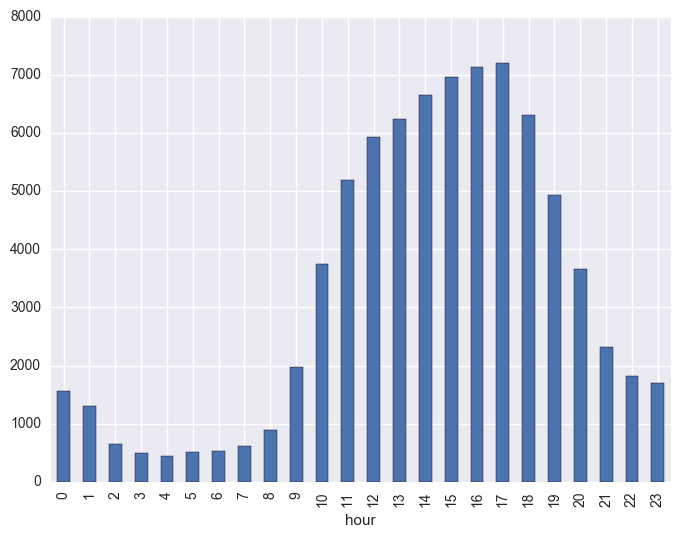

In [11]:
# commits by hour (eastern)

df.groupby('hour').size().plot(kind='bar')

In [12]:
# filter to last 6 months

last_6_mo = df.query('dt > "2016-10-01"').copy()

In [13]:
# by person stats

g = last_6_mo.groupby('name')

In [14]:
# most commits, count (by person)

g.size().sort_values(ascending=False)[:10]

name
bryan allred       865
atul varma         825
noah manger        794
shawn allen        774
dan o. williams    706
joshua carp        593
marco segreto      555
stvnrlly           538
laura gerhardt     529
aidan feldman      466
dtype: int64

In [15]:
# most lines of code added (by person)

g['additions'].sum().sort_values(ascending=False)[:10]

name
aidan feldman       3334241
dan o. williams     2716508
joshua carp         1246368
catherine devlin    1022488
colin craig         1004304
jared cunha          943436
james c. scott       481184
jacob harris         436187
diego lapiduz        280446
greg walker          278008
Name: additions, dtype: int64

In [16]:
# most lines of code deleted (by person) aka the axe-people!

g['deletions'].sum().sort_values(ascending=False)[:10]

name
colin craig         1795393
catherine devlin    1740774
dan o. williams      831319
joshua carp          275915
aaron d borden       237803
greg walker          185570
jacob harris         185552
gray brooks          178398
shawn allen          138641
diego lapiduz        129899
Name: deletions, dtype: int64

In [17]:
# most commits (by repo)

last_6_mo.groupby('repo').size().sort_values(ascending=False)[:10]

repo
e-QIP-prototype    1441
calc               1240
cg-site            1033
18f.gsa.gov        1005
fec-cms             911
identity-idp        869
openFEC-web-app     841
openFEC             775
cg-dashboard        739
handbook            689
dtype: int64

In [18]:
# most common commit messages

df.message.value_counts()[:25]

Update README.md                                                    300
Initial commit                                                      160
hound                                                                87
Private submodule update                                             46
initial commit                                                       45
Add files via upload                                                 43
Update Translations                                                  37
Update index.md                                                      36
Some changes to pages/schools.md                                     36
clean up                                                             33
update standard files                                                28
merge master                                                         26
wip                                                                  24
Merge branch 'master' into vdom                                 

count   78785.000
mean       77.281
std       139.037
min         1.000
25%        27.000
50%        45.000
75%        83.000
max     11606.000
Name: message, dtype: float64
Axes(0.125,0.125;0.775x0.775)


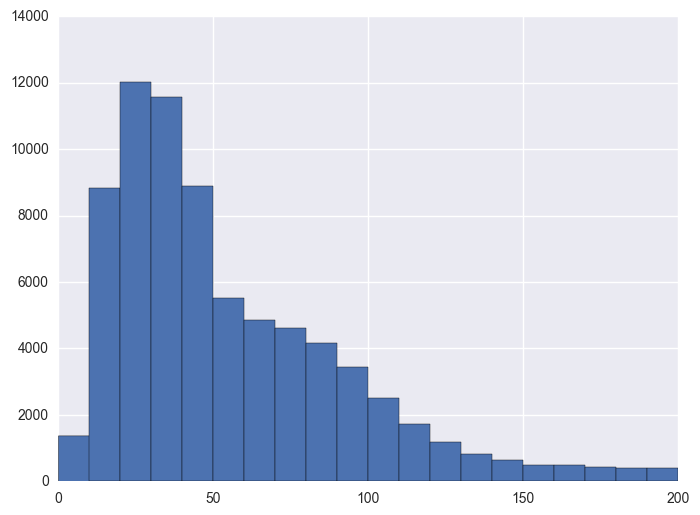

In [19]:
# commit message length

msg_len = df.message.apply(len)

print(msg_len.describe())
print(msg_len.hist(bins=20, range=(0, 200)))

In [20]:
# expand details column (one row per file worked on)  

files = df.details.apply(pd.Series).stack().reset_index(level=1, drop=True)
files.name = 'file'

dg = df.join(files).copy()

print('{} rows'.format(len(dg)))

427765 rows


In [21]:
# clean up new dataframe, remove nulls, add helper cols

keep_cols = ['dt', 'url', 'name', 'repo', 'file']
dh = dg[dg.file.notnull()][keep_cols].copy()

dh['f_name'] = dh['file'].apply(lambda x: x['filename'].split('/')[-1])
dh['f_type'] = dh['f_name'].apply(lambda x: x.split('.')[-1])
for key in ['additions', 'deletions', 'changes']:
    dh['f_{}'.format(key)] = dh['file'].apply(lambda x: x[key])    

dh.head()

,dt,url,name,repo,file,f_name,f_type,f_additions,f_deletions,f_changes
0,2016-06-08 18:57:47,https://github.com/18F/acq-trello-listener/com...,greg walker,acq-trello-listener,"{'additions': 1, 'filename': 'package.json', '...",package.json,json,1,1,2
1,2016-06-08 18:43:27,https://github.com/18F/acq-trello-listener/com...,greg walker,acq-trello-listener,"{'additions': 2, 'filename': '.travis.yml', 'c...",.travis.yml,yml,2,2,4
2,2016-06-08 18:40:17,https://github.com/18F/acq-trello-listener/com...,greg walker,acq-trello-listener,"{'additions': 25, 'filename': '.travis.yml', '...",.travis.yml,yml,25,2,27
3,2016-06-08 15:56:08,https://github.com/18F/acq-trello-listener/com...,greg walker,acq-trello-listener,"{'additions': 1, 'filename': 'manifest.yml', '...",manifest.yml,yml,1,0,1
4,2016-06-07 22:04:51,https://github.com/18F/acq-trello-listener/com...,laura gehardt,acq-trello-listener,"{'additions': 20, 'filename': 'test/webhookHan...",intake.js,js,20,2,22


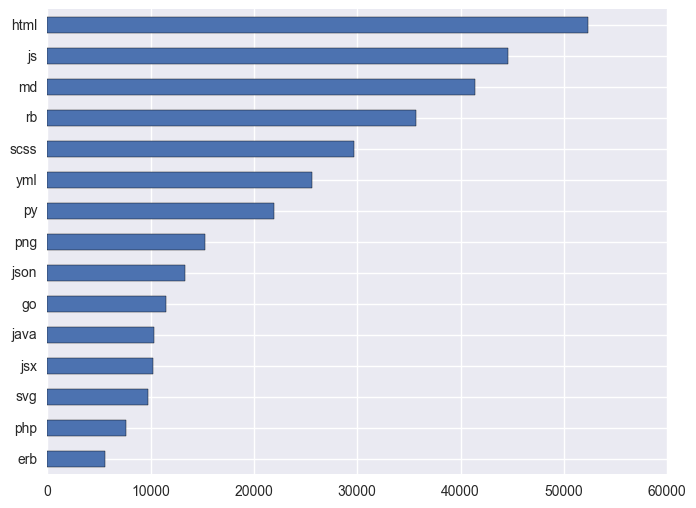

In [22]:
# types of files committed

dh.f_type.value_counts()[:15].iloc[::-1].plot('barh')

In [23]:
# most changes, by file extension, by person

whitelist = ['py', 'rb', 'html', 'js', 'scss', 'go', 'php']

for d in whitelist:
    df_temp = dh.query('f_type == "{}" & f_changes < 500'.format(d))
    top_n = df_temp.groupby('name')['f_changes'].sum().nlargest(5)
    print('{}:\n\n{}\n\n---\n'.format(d.upper(), top_n))

PY:

name
atul varma          60873
lindsayyoung        44405
colin craig         36254
catherine devlin    32002
jonathan carmack    31493
Name: f_changes, dtype: int64

---

RB:

name
peter karman        86572
jessie a. young     63281
alan delevie        54087
jacob harris        51670
moncef belyamani    41470
Name: f_changes, dtype: int64

---

HTML:

name
anthony garvan       160423
john flores           55051
bryan allred          52142
heather battaglia     43675
shawn allen           40876
Name: f_changes, dtype: int64

---

JS:

name
bryan allred        89098
john flores         60345
jeremia kimelman    59158
greg walker         55735
alan delevie        48695
Name: f_changes, dtype: int64

---

SCSS:

name
maya benari         67380
brendan sudol       66903
roger steve ruiz    42645
julia elman         42466
peter karman        38080
Name: f_changes, dtype: int64

---

GO:

name
joshua carp        108304
aidan feldman       59709
etourneau gwenn     46780
james c. scott    